In [25]:
import tensorflow as tf
import keras
from keras.models import load_model
from main import df_val
from metrics import auc_roc
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

CHECKPOINTS_PATH = "output/"
MODEL_CLASSES= ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                'Lung Opacity',
                'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                'Support Devices']

def _load_model(checkpoint_name):
	return load_model(CHECKPOINTS_PATH+checkpoint_name, custom_objects={'auc_roc': auc_roc})

img_data_gen = keras.preprocessing.image.ImageDataGenerator(  # rotation_range=7,
    rescale=1 / 255)

val_gen = img_data_gen.flow_from_dataframe(df_val,
                                           directory=None,
                                           x_col='Path',
                                           y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                                                  'Lung Opacity',
                                                  'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                                                  'Atelectasis',
                                                  'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                                                  'Support Devices'],
                                           target_size=(331, 331),
                                           color_mode='grayscale',
                                           class_mode='raw',
                                           batch_size=64,
                                           shuffle=False,
                                           interpolation='box')

Found 234 validated image filenames.


In [26]:
df_val.sum(axis=0)

Path                          CheXpert-v1.0-small/valid/patient64541/study1/...
Sex                           MaleMaleMaleMaleFemaleFemaleMaleMaleMaleMaleFe...
Age                                                                       14225
Frontal/Lateral               FrontalFrontalLateralFrontalFrontalFrontalFron...
No Finding                                                                   38
Enlarged Cardiomediastinum                                                  109
Cardiomegaly                                                                 68
Lung Opacity                                                                126
Lung Lesion                                                                   1
Edema                                                                        45
Consolidation                                                                33
Pneumonia                                                                     8
Atelectasis                             

In [27]:
model_checkpoints = os.listdir(CHECKPOINTS_PATH)
#for checkpoint in model_checkpoints:


print("loading model...")
#model_file = model_checkpoints[1]
model = _load_model("/model_durchlauf2_LARGE.16-0.40.h5")
#print(f"{model_file} loaded successfully.")



loading model...


In [28]:

print("Predicting...")
preds = model.predict_generator(val_gen)

Predicting...


In [29]:
import numpy as np
df_preds = pd.DataFrame(np.array(preds[0]), columns=MODEL_CLASSES)
df_truth = df_val.iloc[:,5:]

In [30]:
df_preds.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0.124641,0.136318,0.217218,0.318082,0.053613,0.165835,0.067005,0.058808,0.217581,0.025981,0.048998,0.015416,0.103937,0.222567
1,0.424942,0.090139,0.013026,0.205386,0.070719,0.002066,0.065714,0.042545,0.042652,0.016309,0.094593,0.048174,0.051618,0.734029
2,0.433663,0.088787,0.015613,0.177658,0.070032,0.001424,0.049237,0.034328,0.036864,0.028947,0.089181,0.041433,0.062819,0.561681
3,0.023705,0.128763,0.064236,0.681650,0.208870,0.173312,0.176209,0.170765,0.164889,0.129609,0.439298,0.109494,0.089207,0.143929
4,0.419011,0.047412,0.012393,0.293175,0.052134,0.016614,0.075778,0.084673,0.135619,0.049140,0.069006,0.015961,0.051038,0.522117


In [31]:
df_truth.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cardiomegaly auc 0.7880049610205528
Edema auc 0.9047619047619048
Consolidation auc 0.8893411729232626
Atelectasis auc 0.8205357142857144
Pleural Effusion auc 0.9049066047010457


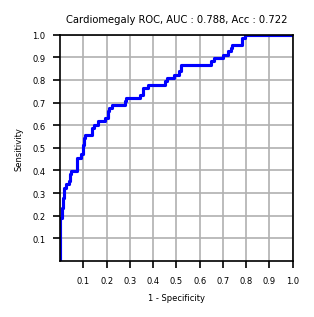

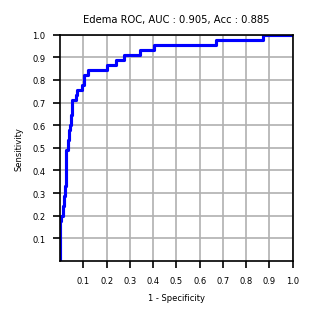

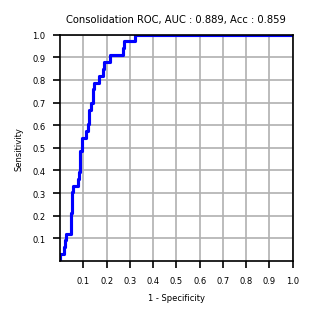

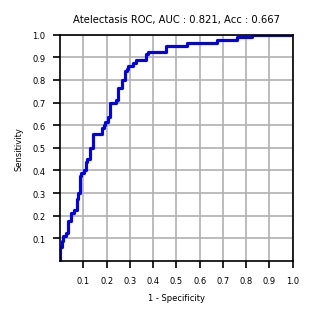

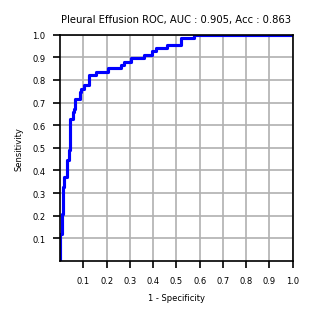

In [32]:
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 4})

benchmark_classes = ['Cardiomegaly', 'Edema','Consolidation','Atelectasis','Pleural Effusion']
for class_label in benchmark_classes:
    i = df_truth.columns.tolist().index(class_label)
    #label = [7,10,11,13,15]#header[i]
    y_pred = df_preds.iloc[:, i].values
    y_true = df_truth.iloc[:, i].values
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(class_label, 'auc', auc)
    acc = metrics.accuracy_score(
        y_true, (y_pred >= 0.5).astype(int), normalize=True
    )

    plt.figure(figsize=(2, 2), dpi=150)
    plt.xlim((0, 1.0))
    plt.ylim((0, 1.0))
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('{} ROC, AUC : {:.3f}, Acc : {:.3f}'.format(class_label, auc, acc))
    plt.plot(fpr, tpr, '-b')
    
    plt.grid()
    plt.savefig(
        os.path.join("./", "Epoch_10"
                     + '_' + MODEL_CLASSES[i] + '_roc.png'), bbox_inches='tight')

Cardiomegaly auc 0.7996102055279943
Edema auc 0.9034685479129924
Consolidation auc 0.8824061510628676
Atelectasis auc 0.8256493506493507
Pleural Effusion auc 0.928322459558495


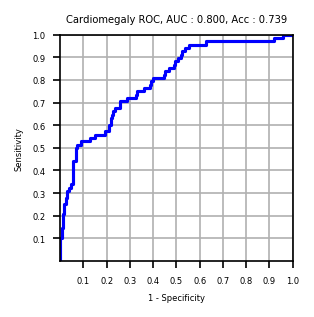

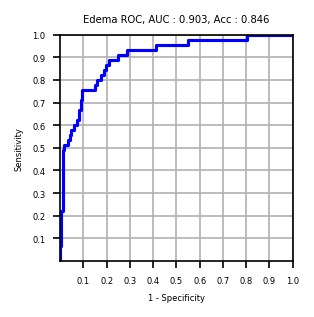

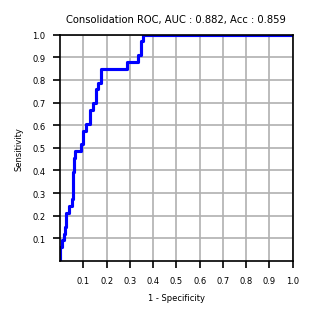

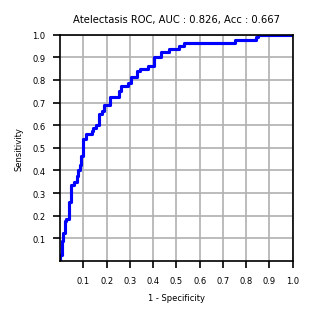

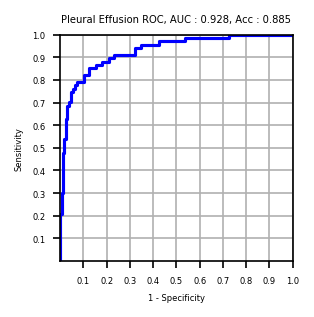

In [10]:
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 4})

benchmark_classes = ['Cardiomegaly', 'Edema','Consolidation','Atelectasis','Pleural Effusion']
for class_label in benchmark_classes:
    i = df_truth.columns.tolist().index(class_label)
    #label = [7,10,11,13,15]#header[i]
    y_pred = df_preds.iloc[:, i].values
    y_true = df_truth.iloc[:, i].values
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(class_label, 'auc', auc)
    acc = metrics.accuracy_score(
        y_true, (y_pred >= 0.5).astype(int), normalize=True
    )

    plt.figure(figsize=(2, 2), dpi=150)
    plt.xlim((0, 1.0))
    plt.ylim((0, 1.0))
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('{} ROC, AUC : {:.3f}, Acc : {:.3f}'.format(class_label, auc, acc))
    plt.plot(fpr, tpr, '-b')
    
    plt.grid()
    plt.savefig(
        os.path.join("./", "Epoch_10"
                     + '_' + MODEL_CLASSES[i] + '_roc.png'), bbox_inches='tight')

In [8]:
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 4})

benchmark_classes = ['Cardiomegaly', 'Edema','Consolidation','Atelectasis','Pleural Effusion']
for class_label in benchmark_classes:
    i = df_truth.columns.tolist().index(class_label)
    #label = [7,10,11,13,15]#header[i]
    y_pred = df_preds.iloc[:, i].values
    y_true = df_truth.iloc[:, i].values
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(class_label, 'auc', auc)
    acc = metrics.accuracy_score(
        y_true, (y_pred >= 0.5).astype(int), normalize=True
    )

    plt.figure(figsize=(2, 2), dpi=150)
    plt.xlim((0, 1.0))
    plt.ylim((0, 1.0))
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('{} ROC, AUC : {:.3f}, Acc : {:.3f}'.format(class_label, auc, acc))
    plt.plot(fpr, tpr, '-b')
    
    plt.grid()
    plt.savefig(
        os.path.join("./", "Epoch_10"
                     + '_' + MODEL_CLASSES[i] + '_roc.png'), bbox_inches='tight')

Cardiomegaly auc 0.763111268603827
Edema auc 0.8871252204585538
Consolidation auc 0.8373285089703
Atelectasis auc 0.8275974025974026
Pleural Effusion auc 0.9246581463937795


Cardiomegaly auc 0.7882707299787385
Edema auc 0.908641975308642
Consolidation auc 0.8882858435097242
Atelectasis auc 0.8050324675324676
Pleural Effusion auc 0.927786218607561


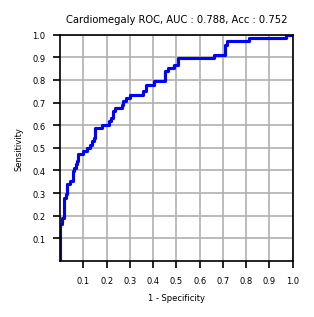

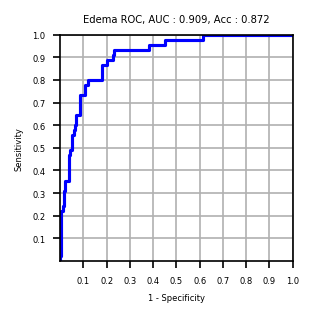

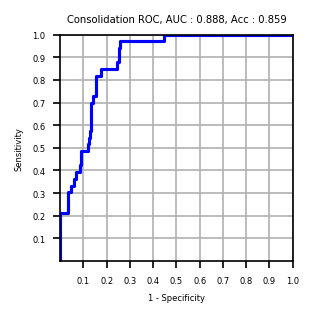

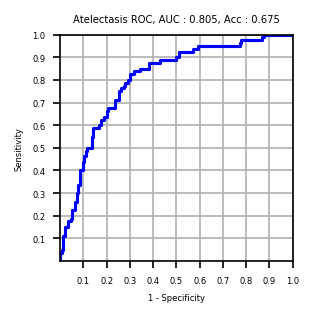

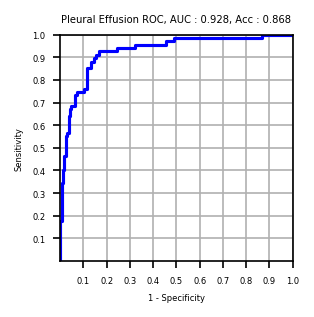

In [29]:
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 4})

benchmark_classes = ['Cardiomegaly', 'Edema','Consolidation','Atelectasis','Pleural Effusion']
for class_label in benchmark_classes:
    i = df_truth.columns.tolist().index(class_label)
    #label = [7,10,11,13,15]#header[i]
    y_pred = df_preds.iloc[:, i].values
    y_true = df_truth.iloc[:, i].values
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(class_label, 'auc', auc)
    acc = metrics.accuracy_score(
        y_true, (y_pred >= 0.5).astype(int), normalize=True
    )

    plt.figure(figsize=(2, 2), dpi=150)
    plt.xlim((0, 1.0))
    plt.ylim((0, 1.0))
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('{} ROC, AUC : {:.3f}, Acc : {:.3f}'.format(class_label, auc, acc))
    plt.plot(fpr, tpr, '-b')
    
    plt.grid()
    plt.savefig(
        os.path.join("./", "Epoch_10"
                     + '_' + MODEL_CLASSES[i] + '_roc.png'), bbox_inches='tight')

## Old Benchmark (MobileNAS)

Cardiomegaly auc 0.7600992204110559
Edema auc 0.897119341563786
Consolidation auc 0.8655208804462535
Atelectasis auc 0.8060876623376624
Pleural Effusion auc 0.9106265081776744


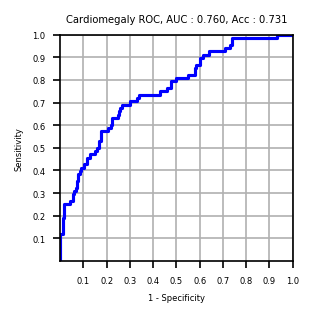

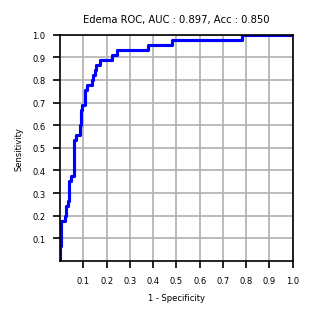

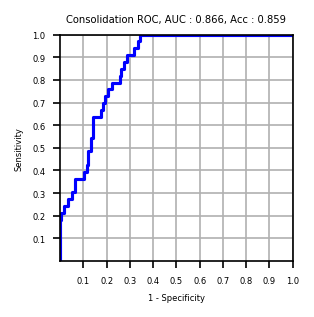

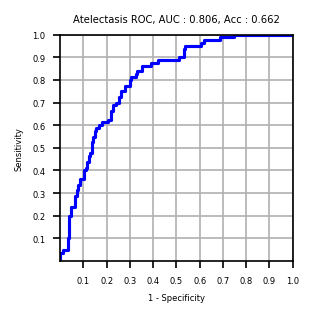

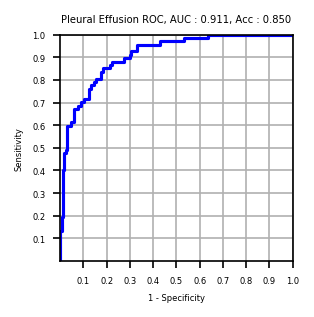

In [77]:
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 4})

benchmark_classes = ['Cardiomegaly', 'Edema','Consolidation','Atelectasis','Pleural Effusion']
for class_label in benchmark_classes:
    i = df_truth.columns.tolist().index(class_label)
    #label = [7,10,11,13,15]#header[i]
    y_pred = df_preds.iloc[:, i].values
    y_true = df_truth.iloc[:, i].values
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(class_label, 'auc', auc)
    acc = metrics.accuracy_score(
        y_true, (y_pred >= 0.5).astype(int), normalize=True
    )

    plt.figure(figsize=(2, 2), dpi=150)
    plt.xlim((0, 1.0))
    plt.ylim((0, 1.0))
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('{} ROC, AUC : {:.3f}, Acc : {:.3f}'.format(class_label, auc, acc))
    plt.plot(fpr, tpr, '-b')
    
    plt.grid()
    plt.savefig(
        os.path.join("./", "Epoch_45"
                     + '_' + MODEL_CLASSES[i] + '_roc.png'), bbox_inches='tight')

In [59]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(iris.target_names))
    plt.xticks(tick_marks, iris.target_names, rotation=45)
    plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(df_truth, df_preds.round(0))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

ValueError: multilabel-indicator is not supported

In [57]:
df_preds.round(0).sum().sum()

361.0

In [58]:
df_truth.sum().sum()

691.0